In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
temp = calc_temps('2017-08-01', '2017-08-07')

temp_df = pd.DataFrame(temp, columns=['tmin','tavg', 'tmax'])
temp_df

,tmin,tavg,tmax
0,72.0,79.25,83.0


Text(0, 0.5, 'Temperature (F)')

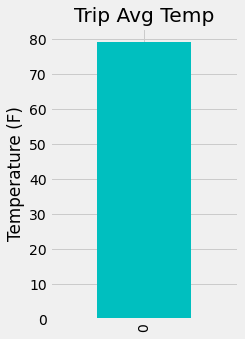

In [12]:
# Plot the results from your previous query as a bar chart. 
temp_df1 = temp_df['tavg']



## Plot Bar Chart and error Bars

temp_df1.plot(kind='bar', figsize=(3,5), color='c', alpha=1)

# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp")

# Use the average temperature for bar height (y value)
plt.ylabel("Temperature (F)")

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

### Daily Rainfall Average

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
result = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp).label('total_rainfall')).\
    filter(Station.station == Measurement.station).\
        filter(Measurement.date >= '2017-08-01').\
            filter(Measurement.date <= '2017-08-07').\
                order_by(func.sum(Measurement.prcp).desc()).\
                    group_by(Station.station).all()
result
pd.DataFrame(result)


,station,name,latitude,longitude,elevation,total_rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


In [14]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date, end_date, freq='D')
# Strip off the year and save a list of strings in the format %m-%d.
print(date_range)
date_M_D = date_range.strftime('%m-%d')
date_M_D


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normal = []
for result in date_M_D:
    # print(result)
    # print(result[0])
    # print(result[0][2])
    normal.append(*daily_normals(result))
    
normal

# result2 = result
# result2

# daily_normals(result1[0])


DatetimeIndex(['2017-08-01', '2017-08-02', '2017-08-03', '2017-08-04',
               '2017-08-05', '2017-08-06', '2017-08-07'],
              dtype='datetime64[ns]', freq='D')


[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [21]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normal, columns=['tmin', 'tavg', 'tmax'])
df['dates'] = date_range
df1 = df.set_index(['dates'])

df1

,tmin,tavg,tmax
dates,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


<AxesSubplot:xlabel='dates'>

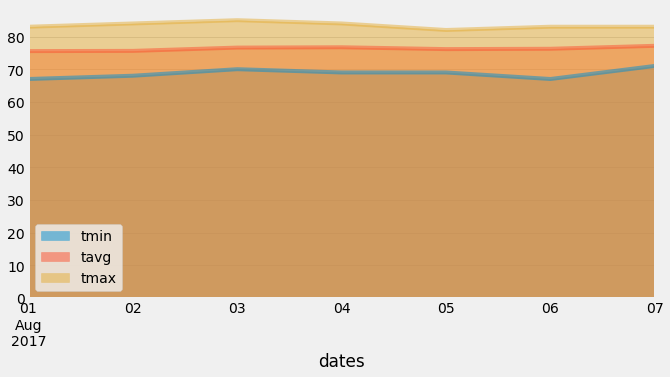

In [25]:
# Plot the daily normals as an area plot with `stacked=False`

df1.plot(kind='area', stacked=False, figsize=(10,5))

## Close Session